In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [4]:
x_train = x_train[..., tf.newaxis] #adds a additional axis (60000,28,28) --> (60000,28,28,1) 
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
tf.random.normal(shape=x_train.shape)

<tf.Tensor: shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[ 1.1408988 ],
         [ 0.55662715],
         [ 1.2448927 ],
         ...,
         [ 2.4796078 ],
         [-0.35619098],
         [ 2.0493813 ]],

        [[ 0.590492  ],
         [-0.64227396],
         [-0.86894685],
         ...,
         [ 0.9639196 ],
         [ 0.51724815],
         [-0.52437073]],

        [[ 1.3884516 ],
         [ 0.49889678],
         [-0.12217156],
         ...,
         [-1.06453   ],
         [-1.9028096 ],
         [ 1.4367089 ]],

        ...,

        [[-1.5894766 ],
         [-1.6408037 ],
         [-1.4500307 ],
         ...,
         [-1.0039101 ],
         [ 1.3799392 ],
         [-0.100451  ]],

        [[ 0.73287654],
         [-1.1835335 ],
         [ 0.9116689 ],
         ...,
         [-0.78105104],
         [ 0.83329767],
         [-0.97037244]],

        [[-0.9906631 ],
         [ 0.48040625],
         [-0.46420038],
         ...,
         [ 2.6651769 ],
         [ 1.086

In [6]:
noise_factor = 0.2
x_train_noisy = x_train  +  noise_factor * tf.random.normal(shape=x_train.shape) 
# noise factor multiplication result in increased spread in noise distribution
# result in 0.2^2 increase of variance, mean doesn't chnage (mean = 0) 
x_test_noisy = x_test  +  noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [7]:
x_test_noisy.shape

TensorShape([10000, 28, 28, 1])

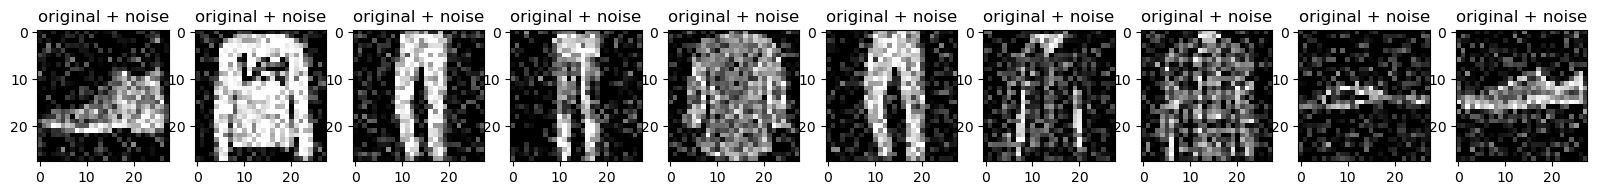

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [9]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
autoencoder = Denoise()

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [12]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10

1875/1875 [==============================] - 20s 9ms/step - loss: 0.0160 - val_loss: 0.0095
Epoch 2/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 5/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 6/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 7/10
1875/1875 [==============================] - 22s 11ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 8/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 9/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 10/10
1875/1875 [==============================] - 12s 6ms/step 

In [13]:
autoencoder.encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
autoencoder.decoder.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

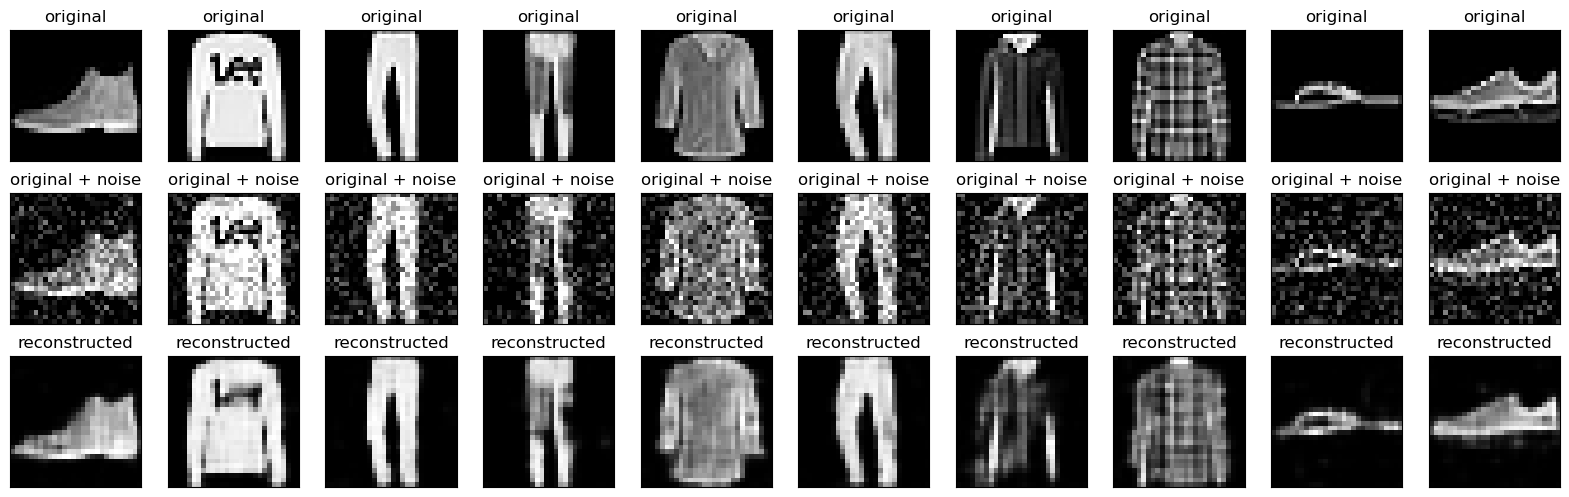

In [16]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original 
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Answers

###  Train the model with 30 epochs.

In [42]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [43]:
autoencoder = Denoise()

In [44]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [45]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/30
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0170 - val_loss: 0.0106
Epoch 2/30
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 3/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 4/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 5/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 6/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 7/30
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 8/30
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 9/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 10/30
1875/1875 [==============================] - 11s 6ms/step - l

In [46]:
autoencoder.encoder.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
autoencoder.decoder.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_4 (Conv2D  (None, 14, 14, 8)         584       
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

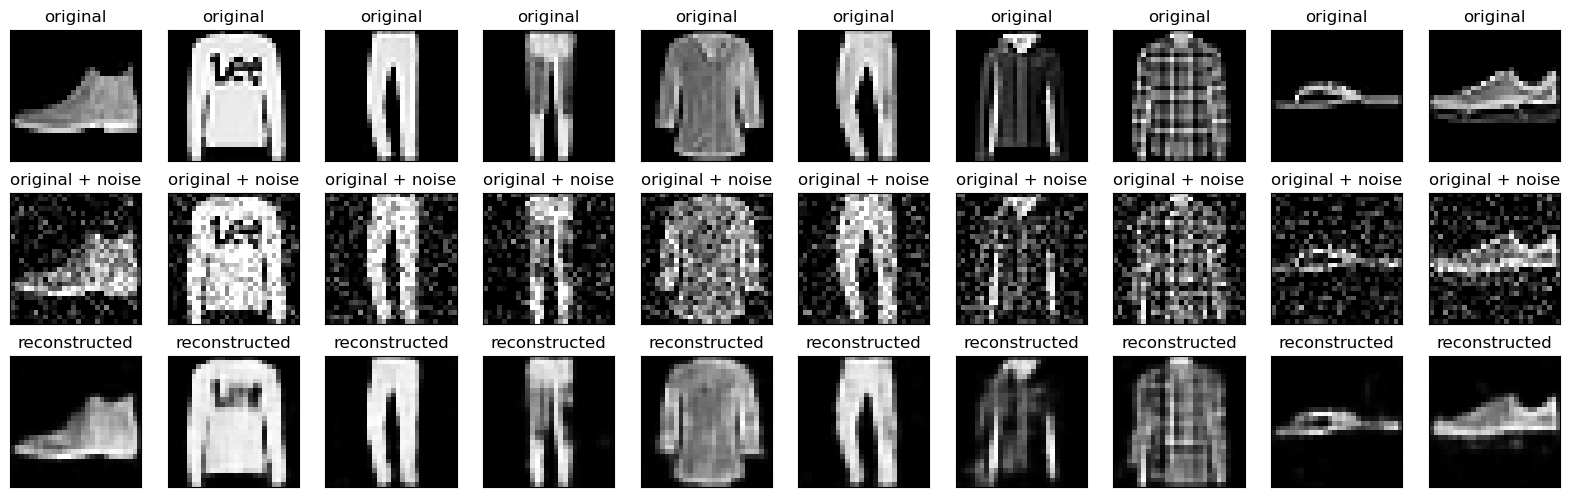

In [50]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original 
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

### Write the code implementation to calculate the loss (Mean Squared Error) for the test dataset.

In [60]:
from sklearn.metrics import mean_squared_error


decoded_imgs_test = autoencoder.predict(x_test)
x_test_flat = x_test.reshape(len(x_test), -1)
decoded_imgs_test_flat = decoded_imgs_test.reshape(len(decoded_imgs_test), -1)

# Mean Squared Error
mse_test = mean_squared_error(x_test_flat, decoded_imgs_test_flat)
print(f"Mean Squared Error : {mse_test:.4f}")

313/313 [==============================] - 1s 3ms/step
Mean Squared Error : 0.0046


Epoch 1/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 2/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 3/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 4/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 7/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/30
1875/1875 [==============================] - 11s 6ms/step - l

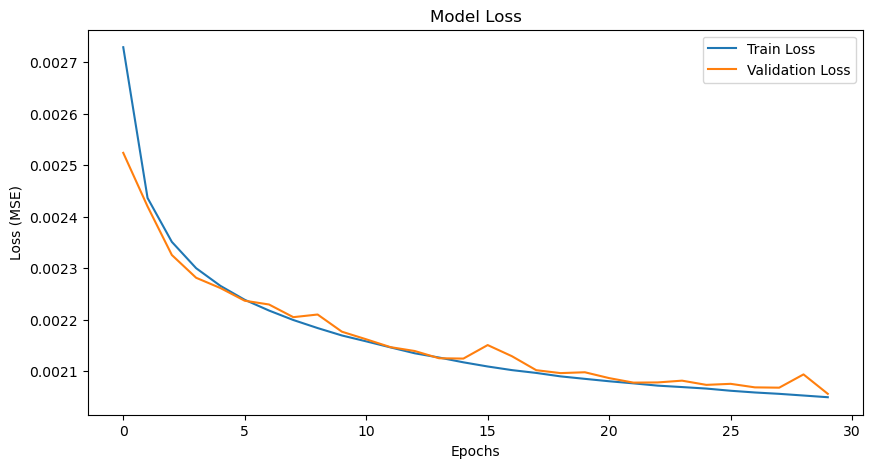

In [67]:
import matplotlib.pyplot as plt


history = autoencoder.fit(x_train, x_train,
                          epochs=30,
                          shuffle=True,
                          validation_data=(x_test, x_test))

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()


In [76]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# List of noise_factor values to try
noise_factors = [0.05, 0.1, 0.3, 0.4, 0.5]
best_noise_factor = None
best_val_loss = np.inf  # Set to infinity initially

for noise_factor in noise_factors:
    print(f"Testing with noise_factor: {noise_factor}")
    
    # Add noise to the training and testing data
    x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
    x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
    
    # Clip the values to be between 0 and 1
    x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
    x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)
    
    class Denoise(Model):
        def __init__(self):
            super(Denoise, self).__init__()
            self.encoder = tf.keras.Sequential([
                layers.Input(shape=(28, 28, 1)),
                layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
                layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
            ])
            self.decoder = tf.keras.Sequential([
                layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
                layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
                layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
            ])
    
        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    autoencoder = Denoise()
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    
    # Train the model and store training history
    history = autoencoder.fit(x_train_noisy, x_train,
                              epochs=30,  # Train with 30 epochs
                              shuffle=True,
                              validation_data=(x_test_noisy, x_test))
    
    # Get the final validation loss for this noise_factor
    final_val_loss = history.history['val_loss'][-1]
    
    # Compare and store the best noise_factor
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_noise_factor = noise_factor

    print(f"Noise factor: {noise_factor}, Validation Loss: {final_val_loss}")

# Output the best noise factor
print(f"\nBest noise_factor: {best_noise_factor} with Validation Loss: {best_val_loss}")


Testing with noise_factor: 0.05
Epoch 1/30
1875/1875 [==============================] - 11s 5ms/step - loss: 0.0140 - val_loss: 0.0064
Epoch 2/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 3/30
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 4/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/30
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 7/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/30
1875/1875 [==================